In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense


In [11]:
'''import random
import numpy as np
import tensorflow as tf

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1' '''


"import random\nimport numpy as np\nimport tensorflow as tf\n\n# Set random seeds\nrandom.seed(42)\nnp.random.seed(42)\ntf.random.set_seed(42)\n\nimport os\nos.environ['TF_DETERMINISTIC_OPS'] = '1' "

In [12]:
# Load dataset
df = pd.read_csv("medicines.csv")

# Display first 5 rows of the dataset
print("Dataset Preview:")
print(df.head())


Dataset Preview:
                                       Symptoms  \
0  body pain, acidity, stomach pain, runny nose   
1                           bacterial infection   
2                   swelling, fever, runny nose   
3                                    runny nose   
4             fever, swelling, cold, runny nose   

                             Medicines  
0       cetirizine, diclofenac, aciloc  
1                         azithromycin  
2  paracetamol, cetirizine, diclofenac  
3                           cetirizine  
4  paracetamol, cetirizine, diclofenac  


In [13]:
# Convert medicines column into list format
df["Medicines"] = df["Medicines"].apply(lambda x: x.split(", "))

# Display unique medicines
unique_medicines = set([med for sublist in df["Medicines"] for med in sublist])
print("\nUnique Medicines:", unique_medicines)



Unique Medicines: {'diclofenac', 'azithromycin', 'cetirizine', 'aciloc', 'paracetamol'}


In [14]:

# Tokenize symptoms
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Symptoms"])
X = tokenizer.texts_to_sequences(df["Symptoms"])
X = pad_sequences(X, maxlen=5)  # Max length set to 5

# One-hot encode medicines for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["Medicines"])

# Get medicine names
medicine_list = mlb.classes_



In [15]:
# Split 80% Training, 10% Testing, 10% Validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% goes to temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 10% test, 10% validation


In [16]:
# Display dataset sizes
print("\nDataset Sizes:")
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Dataset Sizes:
Training Set: (8000, 5), Validation Set: (1000, 5), Test Set: (1000, 5)


In [17]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=16, input_length=5),  # Changed from 10 to 5
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(len(medicine_list), activation='sigmoid')  # Multi-label classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 16)             304       
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             3136      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5685 (22.21 KB)
Trainable params: 5685 (22.21 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [18]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Epoch 1/10
250/250 [==============================] - 2s 4ms/step - loss: 0.4261 - accuracy: 0.4257 - val_loss: 0.2135 - val_accuracy: 0.5810
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.1348 - accuracy: 0.5838 - val_loss: 0.1110 - val_accuracy: 0.5420
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0939 - accuracy: 0.5297 - val_loss: 0.1038 - val_accuracy: 0.5090
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0894 - accuracy: 0.5190 - val_loss: 0.1003 - val_accuracy: 0.5190
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0862 - accuracy: 0.5207 - val_loss: 0.0993 - val_accuracy: 0.5170
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0844 - accuracy: 0.5167 - val_loss: 0.1004 - val_accuracy: 0.5240
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0834 - accuracy: 0.5213 - val_loss: 0.0978 - val_accuracy: 0.5170
Epoch 

In [19]:
threshold = 0.5
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > threshold).astype(int)


precision = precision_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_prob, average='micro')


print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")



32/32 [==============================] - 0s 3ms/step
Precision: 0.9864
F1-score: 0.9626
Accuracy: 0.8540
Recall: 0.9400
AUC: 0.9917


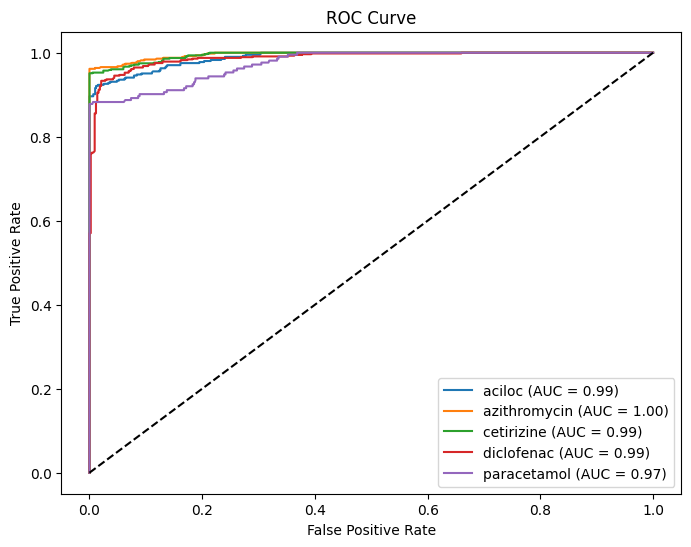

In [20]:
plt.figure(figsize=(8,6))
for i in range(len(medicine_list)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{medicine_list[i]} (AUC = {roc_auc_score(y_test[:, i], y_pred_prob[:, i]):.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


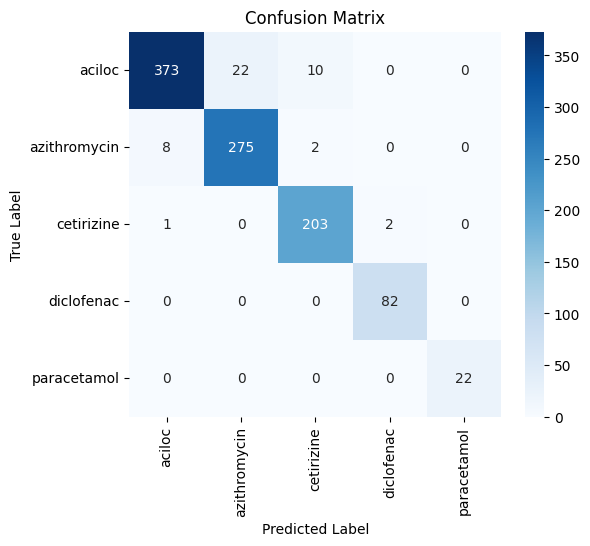

In [21]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=medicine_list, yticklabels=medicine_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
model.save("medicine_model.h5")


d:\desktop files\MediFlex final medicine recommendation\final medicine recommendation\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
import pickle
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)
with open("medicine_labels.pkl", "wb") as handle:
    pickle.dump(medicine_list, handle)
